In [1]:
import pandas as pd
import csv
import pickle as pkl
import numpy as np
from fasttext import FastText
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime


In [2]:
model = FastText.load_model('cc.en.300.bin')

In [3]:
class Embeddings:
    def __init__(self, model) -> None:
        self.model = model
    def get_embeddings(self, words):
        return np.array([self.model.get_word_vector(i) for i in words])
    

In [4]:
tags = pkl.load(open('./tags.pkl', 'rb'))

In [5]:
embedding_class = Embeddings(model)
ems = embedding_class.get_embeddings(tags[:100])

In [179]:
anew_dataset = pd.read_csv('./anew_raw.csv')

In [237]:
anew_dict= dict()
words = anew_dataset['term']
valence_ratings = anew_dataset['pleasure']
arousal_ratings = anew_dataset['arousal']
word_embeddings = embedding_class.get_embeddings(words)
word_embedding_dict = dict(zip(words, word_embeddings))
for i in range(len(words)):
    anew_dict[words[i]] = [valence_ratings[i], arousal_ratings[i]]

In [238]:
X = word_embeddings
Y = np.array([anew_dict[i] for i in words])

In [239]:
Y

array([[2.76, 5.53],
       [3.5 , 5.39],
       [4.26, 4.36],
       ...,
       [6.89, 5.64],
       [6.75, 5.67],
       [6.79, 5.59]])

In [240]:
X

array([[-0.01757489,  0.00900055,  0.04521811, ..., -0.03663422,
        -0.01874213,  0.02927855],
       [ 0.01350051,  0.01367358,  0.04860941, ...,  0.00306123,
         0.01319353,  0.00415528],
       [-0.00513506,  0.0177588 ,  0.01257944, ..., -0.04399451,
         0.01500077,  0.00711149],
       ...,
       [-0.04741758,  0.01749353,  0.01445963, ...,  0.00189274,
        -0.01372969,  0.00194703],
       [-0.03955808, -0.04955037,  0.07052619, ..., -0.01337917,
        -0.00564315, -0.00576652],
       [-0.04456862, -0.02361453,  0.12920032, ..., -0.02449321,
        -0.01248372,  0.00415398]], dtype=float32)

In [241]:

Y = Y/10
# SCaling the data -- large loss issues. 

In [242]:
Y

array([[0.276, 0.553],
       [0.35 , 0.539],
       [0.426, 0.436],
       ...,
       [0.689, 0.564],
       [0.675, 0.567],
       [0.679, 0.559]])

In [243]:
X

array([[-0.01757489,  0.00900055,  0.04521811, ..., -0.03663422,
        -0.01874213,  0.02927855],
       [ 0.01350051,  0.01367358,  0.04860941, ...,  0.00306123,
         0.01319353,  0.00415528],
       [-0.00513506,  0.0177588 ,  0.01257944, ..., -0.04399451,
         0.01500077,  0.00711149],
       ...,
       [-0.04741758,  0.01749353,  0.01445963, ...,  0.00189274,
        -0.01372969,  0.00194703],
       [-0.03955808, -0.04955037,  0.07052619, ..., -0.01337917,
        -0.00564315, -0.00576652],
       [-0.04456862, -0.02361453,  0.12920032, ..., -0.02449321,
        -0.01248372,  0.00415398]], dtype=float32)

In [244]:
pkl.dump(X, open('X.pkl', 'wb'))
pkl.dump(Y, open('Y.pkl', 'wb'))


In [245]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [246]:
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
test_dataset = TensorDataset(X_test, y_test)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [247]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [248]:
device

'cpu'

In [312]:
class NetworkModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.input = nn.Linear(300, 150)
        self.linear_stack = nn.Sequential(
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(150, 100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(50, 25),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(25, 10),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
        )
        self.output = nn.Linear(5, 2)

    def forward(self, x):
        x = self.input(x)
        x = self.linear_stack(x)
        x = self.output(x)
        return x



In [341]:
train = True
if(train == True):
    best_loss = 10000
    model_train = NetworkModel().to(device)
    best_model = model_train.state_dict()
    epochs = 400
    learning_rate = 10e-5
    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model_train.parameters(), lr=learning_rate)
    test_loss = []
    train_loss = []
    for i in range(epochs):
        for X, Y in train_loader:
            X, Y = X.to(device), Y.to(device)
            Y_pred = model_train(X.float())
            loss = loss_fn(Y_pred, Y.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss.append(loss.item())
        # Test Loss
        with torch.no_grad():
            for X, Y in test_loader:
                X, Y = X.to(device), Y.to(device)
                Y_pred = model_train(X.float())
                test_loss_fn = loss_fn(Y_pred, Y.float())
            print(f'Epoch {i}, Training Loss: {loss.item()}, Test Loss: {test_loss_fn.item()}')
            test_loss.append(test_loss_fn.item())
            if(test_loss_fn.item() < best_loss):
                best_loss = test_loss_fn.item()
                best_model = model_train.state_dict()

Epoch 0, Training Loss: 0.08247721940279007, Test Loss: 0.15474167466163635
Epoch 1, Training Loss: 0.10086717456579208, Test Loss: 0.13925370573997498
Epoch 2, Training Loss: 0.09681010991334915, Test Loss: 0.12486376613378525
Epoch 3, Training Loss: 0.05952098220586777, Test Loss: 0.07109411805868149
Epoch 4, Training Loss: 0.09877323359251022, Test Loss: 0.08328612148761749
Epoch 5, Training Loss: 0.08130630105733871, Test Loss: 0.05815046280622482
Epoch 6, Training Loss: 0.060287538915872574, Test Loss: 0.06814728677272797
Epoch 7, Training Loss: 0.04370872676372528, Test Loss: 0.05569403991103172
Epoch 8, Training Loss: 0.061937104910612106, Test Loss: 0.04260099679231644
Epoch 9, Training Loss: 0.05423693731427193, Test Loss: 0.04604612663388252
Epoch 10, Training Loss: 0.059309206902980804, Test Loss: 0.04970502853393555
Epoch 11, Training Loss: 0.027653364464640617, Test Loss: 0.05785840377211571
Epoch 12, Training Loss: 0.03526408225297928, Test Loss: 0.0643867626786232
Epoch 

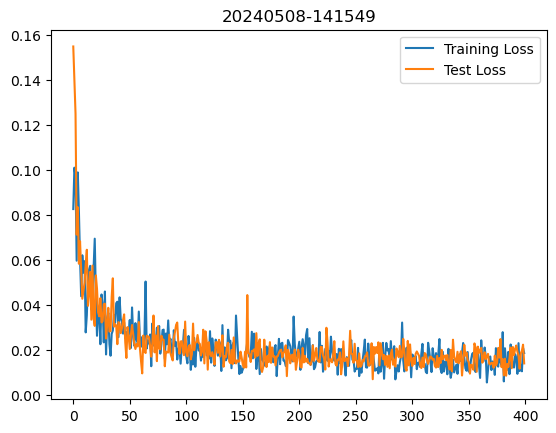

In [342]:
plt.plot(train_loss[:], label='Training Loss')
plt.plot(test_loss[:], label='Test Loss')
plt.legend()
datestring = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
plt.title(datestring)
plt.savefig(f'./train_logs/{datestring}.png')

In [343]:
array = []
for i in range(len(X_test)):
    X_out = model_train(X_test[i].float())
    # print(X_out)
    Y_out= y_test[i]
    # print(Y_out)
    array.append((sum((X_out - Y_out)**2)))
    # array.append(loss_fn(X_out, Y_out).item())

In [344]:
array.sort()

In [345]:
array

[tensor(0.0002, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(0.0003, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(0.0003, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(0.0005, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(0.0006, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(0.0007, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(0.0007, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(0.0008, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(0.0012, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(0.0014, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(0.0014, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(0.0015, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(0.0017, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(0.0020, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(0.0021, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(0.0022, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(

In [316]:
test_loss[-1]

0.5843913555145264

In [317]:
X

tensor([[-0.0020, -0.0187,  0.0377,  ..., -0.0226, -0.0595, -0.0045],
        [ 0.0034, -0.0226,  0.0915,  ...,  0.0093, -0.0150,  0.0231],
        [ 0.0226,  0.0108,  0.0977,  ..., -0.1008, -0.1237,  0.0390],
        ...,
        [-0.0056, -0.0257,  0.0846,  ..., -0.0313,  0.0177,  0.0529],
        [ 0.0178,  0.0337,  0.0464,  ..., -0.0081, -0.0666,  0.0211],
        [-0.0062,  0.0213,  0.0555,  ..., -0.0422, -0.0054, -0.0326]])

In [318]:
best_loss

0.21584318578243256

In [319]:
new_model = NetworkModel()
new_model.load_state_dict(best_model)

<All keys matched successfully>

In [320]:
i = 12
X_out = new_model(X_train[i].float())
print(X_out)
Y_out= y_train[i]
print(Y_out)
print((sum((X_out - Y_out)**2)))
loss_fn(X_out, Y_out)

tensor([0.9158, 0.5822], grad_fn=<ViewBackward0>)
tensor([0.8320, 0.8100], dtype=torch.float64)
tensor(0.0589, dtype=torch.float64, grad_fn=<AddBackward0>)


tensor(0.0589, dtype=torch.float64, grad_fn=<MseLossBackward0>)